In [2]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention_gl1 as SelfAttention,CrossAttention_gl1 as CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [5]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

35

In [6]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [7]:
test_titles = sorted(dnf_eval.headline.unique())

In [8]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


(200, 50, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

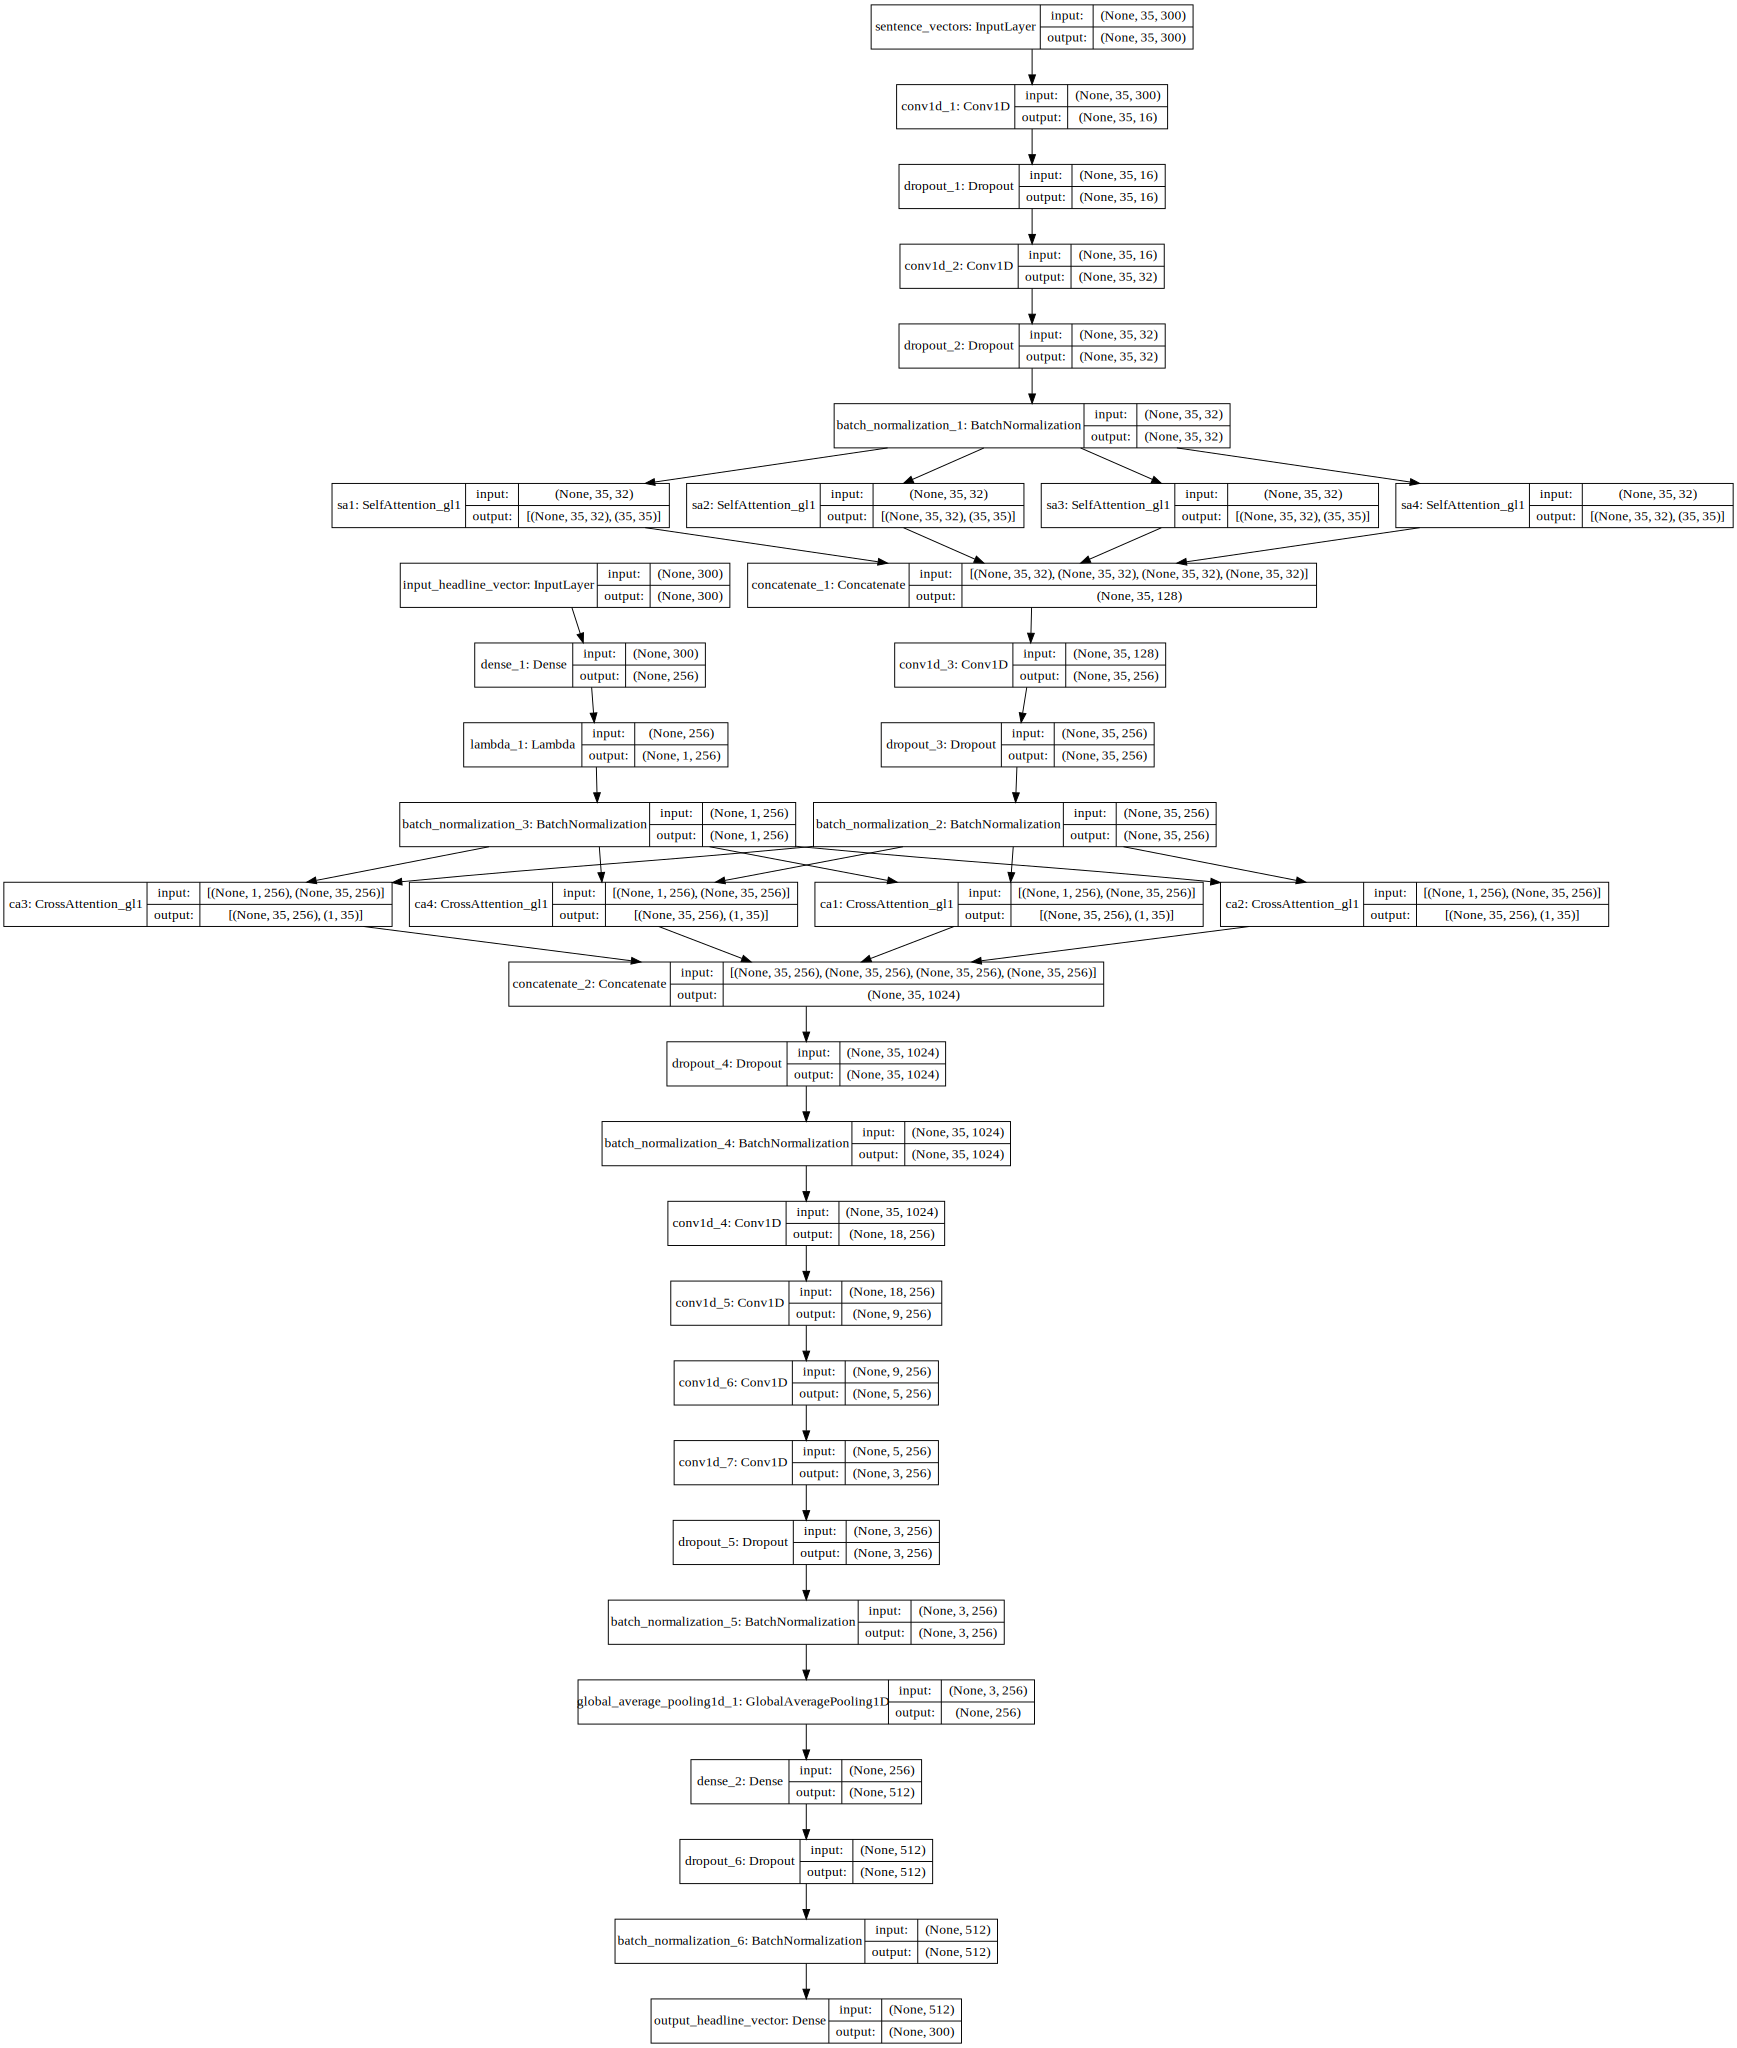

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_vector_gl1.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_vector_gl1/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 16s 4s/step - loss: 1.2865 - val_loss: 0.2577
Epoch 2/2000
4/4 [==============================] - 0s 60ms/step - loss: 1.2715 - val_loss: 0.2264
Epoch 3/2000
4/4 [==============================] - 0s 72ms/step - loss: 1.2476 - val_loss: 0.2135
Epoch 4/2000
4/4 [==============================] - 3s 633ms/step - loss: 1.2556 - val_loss: 0.2077
Epoch 5/2000
4/4 [==============================] - 4s 1s/step - loss: 1.2393 - val_loss: 0.1991
Epoch 6/2000
4/4 [==============================] - 5s 1s/step - loss: 1.2625 - val_loss: 0.1927
Epoch 7/2000
4/4 [==============================] - 4s 1s/step - loss: 1.2182 - val_loss: 0.1902
Epoch 8/2000
4/4 [==============================] - 4s 1s/step - loss: 1.2373 - val_loss: 0.1816
Epoch 9/2000
4/4 [==============================] - 4s 1s/step - loss: 1.2055 - val_loss: 0.1796
Epoch 10/2000
4/4 [==============================] - 4s 1s/step - loss: 1.2059 - val_loss: 0.1718
Epoch 11/2000
4/4 [==

4/4 [==============================] - 5s 1s/step - loss: 0.7666 - val_loss: 0.0877
Epoch 85/2000
4/4 [==============================] - 5s 1s/step - loss: 0.7551 - val_loss: 0.0851
Epoch 86/2000
4/4 [==============================] - 4s 1s/step - loss: 0.7428 - val_loss: 0.0818
Epoch 87/2000
4/4 [==============================] - 6s 1s/step - loss: 0.7439 - val_loss: 0.0844
Epoch 88/2000
4/4 [==============================] - 6s 2s/step - loss: 0.7439 - val_loss: 0.0797
Epoch 89/2000
4/4 [==============================] - 5s 1s/step - loss: 0.7320 - val_loss: 0.0831
Epoch 90/2000
4/4 [==============================] - 6s 1s/step - loss: 0.7539 - val_loss: 0.0781
Epoch 91/2000
4/4 [==============================] - 5s 1s/step - loss: 0.7349 - val_loss: 0.0766
Epoch 92/2000
4/4 [==============================] - 5s 1s/step - loss: 0.7073 - val_loss: 0.0788
Epoch 93/2000
4/4 [==============================] - 6s 1s/step - loss: 0.7159 - val_loss: 0.0744
Epoch 94/2000
4/4 [===============

4/4 [==============================] - 6s 1s/step - loss: 0.4571 - val_loss: 0.0365
Epoch 168/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4481 - val_loss: 0.0375
Epoch 169/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4345 - val_loss: 0.0379
Epoch 170/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4369 - val_loss: 0.0377
Epoch 171/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4464 - val_loss: 0.0388
Epoch 172/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4420 - val_loss: 0.0389
Epoch 173/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4291 - val_loss: 0.0410
Epoch 174/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4373 - val_loss: 0.0377
Epoch 175/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4255 - val_loss: 0.0439
Epoch 176/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4312 - val_loss: 0.0478
Epoch 177/2000
4/4 [=====

Epoch 250/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3034 - val_loss: 0.0153
Epoch 251/2000
4/4 [==============================] - 6s 1s/step - loss: 0.2967 - val_loss: 0.0161
Epoch 252/2000
4/4 [==============================] - 7s 2s/step - loss: 0.2977 - val_loss: 0.0170
Epoch 253/2000
4/4 [==============================] - 6s 1s/step - loss: 0.2943 - val_loss: 0.0179
Epoch 254/2000
4/4 [==============================] - 5s 1s/step - loss: 0.2945 - val_loss: 0.0181
Epoch 255/2000
4/4 [==============================] - 6s 2s/step - loss: 0.2873 - val_loss: 0.0169
Epoch 256/2000
4/4 [==============================] - 7s 2s/step - loss: 0.2995 - val_loss: 0.0178
Epoch 257/2000
4/4 [==============================] - 6s 1s/step - loss: 0.2854 - val_loss: 0.0173
Epoch 258/2000
4/4 [==============================] - 6s 2s/step - loss: 0.2956 - val_loss: 0.0160
Epoch 259/2000
4/4 [==============================] - 6s 1s/step - loss: 0.2898 - val_loss: 0.0207
Epoch 260/

4/4 [==============================] - 6s 2s/step - loss: 0.1883 - val_loss: 0.0269
Epoch 333/2000
4/4 [==============================] - 7s 2s/step - loss: 0.2099 - val_loss: 0.0298
Epoch 334/2000
4/4 [==============================] - 7s 2s/step - loss: 0.1765 - val_loss: 0.0295
Epoch 335/2000
4/4 [==============================] - 6s 2s/step - loss: 0.1761 - val_loss: 0.0260
Epoch 336/2000
4/4 [==============================] - 6s 1s/step - loss: 0.1724 - val_loss: 0.0245
Epoch 337/2000
4/4 [==============================] - 6s 1s/step - loss: 0.1759 - val_loss: 0.0247
Epoch 338/2000
4/4 [==============================] - 6s 1s/step - loss: 0.2060 - val_loss: 0.0227
Epoch 339/2000
4/4 [==============================] - 6s 1s/step - loss: 0.1978 - val_loss: 0.0247
Epoch 340/2000
4/4 [==============================] - 5s 1s/step - loss: 0.1705 - val_loss: 0.0193
Epoch 341/2000
4/4 [==============================] - 6s 1s/step - loss: 0.1745 - val_loss: 0.0218
Epoch 342/2000
4/4 [=====

Epoch 415/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0135
Epoch 416/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0108
Epoch 417/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0112
Epoch 418/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0116
Epoch 419/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0152
Epoch 420/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0093 - val_loss: 0.0115
Epoch 421/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0124
Epoch 422/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0111
Epoch 423/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0108 - val_loss: 0.0122
Epoch 424/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0111
Epoch 425/

4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0134
Epoch 498/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0138
Epoch 499/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0131
Epoch 500/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0115
Epoch 501/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0119
Epoch 502/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0125
Epoch 503/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0112
Epoch 504/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0095 - val_loss: 0.0116
Epoch 505/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0102
Epoch 506/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0123
Epoch 507/2000
4/4 [=====

Epoch 580/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0113
Epoch 581/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0102 - val_loss: 0.0108
Epoch 582/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - val_loss: 0.0115
Epoch 583/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0096 - val_loss: 0.0109
Epoch 584/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0120
Epoch 585/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0131
Epoch 586/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0120
Epoch 587/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0123
Epoch 588/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0133
Epoch 589/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0126
Epoch 590/

4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0111
Epoch 663/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0098 - val_loss: 0.0129
Epoch 664/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0114
Epoch 665/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0127
Epoch 666/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0129
Epoch 667/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0097 - val_loss: 0.0101
Epoch 668/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0111
Epoch 669/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0116
Epoch 670/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0096 - val_loss: 0.0138
Epoch 671/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0112
Epoch 672/2000
4/4 [=====

Epoch 745/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0120
Epoch 746/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0102 - val_loss: 0.0128
Epoch 747/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0122
Epoch 748/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - val_loss: 0.0127
Epoch 749/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0104
Epoch 750/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0117
Epoch 751/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0120
Epoch 752/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0118
Epoch 753/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0123
Epoch 754/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0102 - val_loss: 0.0108
Epoch 755/

4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0146
Epoch 828/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0115
Epoch 829/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0096 - val_loss: 0.0131
Epoch 830/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0108
Epoch 831/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0101
Epoch 832/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0107
Epoch 833/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0098 - val_loss: 0.0116
Epoch 834/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0099
Epoch 835/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0133
Epoch 836/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0096 - val_loss: 0.0115
Epoch 837/2000
4/4 [=====

Epoch 910/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0133
Epoch 911/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0119
Epoch 912/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0118
Epoch 913/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0114
Epoch 914/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0135
Epoch 915/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0095
Epoch 916/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 917/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0114
Epoch 918/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0121
Epoch 919/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0119
Epoch 920/

4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0121
Epoch 993/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0124
Epoch 994/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0107
Epoch 995/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0112
Epoch 996/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0132
Epoch 997/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0103
Epoch 998/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0101 - val_loss: 0.0111
Epoch 999/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0117
Epoch 1000/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0119
Epoch 1001/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0134
Epoch 1002/2000
4/4 [==

4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0140
Epoch 1075/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0130
Epoch 1076/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0097 - val_loss: 0.0132
Epoch 1077/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0097 - val_loss: 0.0122
Epoch 1078/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0117
Epoch 1079/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0091
Epoch 1080/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0115
Epoch 1081/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0140
Epoch 1082/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0147
Epoch 1083/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0130
Epoch 1084/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0126
Epoch 1157/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0130
Epoch 1158/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0114
Epoch 1159/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0095 - val_loss: 0.0106
Epoch 1160/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0123
Epoch 1161/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0101 - val_loss: 0.0121
Epoch 1162/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0116
Epoch 1163/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0110
Epoch 1164/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0097
Epoch 1165/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0121
Epoch 1166/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 1239/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0130
Epoch 1240/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0114
Epoch 1241/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0124
Epoch 1242/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0124
Epoch 1243/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0118
Epoch 1244/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0134
Epoch 1245/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0124
Epoch 1246/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0133
Epoch 1247/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0101 - val_loss: 0.0120
Epoch 1248/2000


4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0153
Epoch 1321/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0113
Epoch 1322/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - val_loss: 0.0121
Epoch 1323/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0126
Epoch 1324/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0109 - val_loss: 0.0108
Epoch 1325/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0118
Epoch 1326/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0096 - val_loss: 0.0105
Epoch 1327/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0117
Epoch 1328/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0102
Epoch 1329/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - val_loss: 0.0119
Epoch 1330/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0106
Epoch 1403/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0098 - val_loss: 0.0138
Epoch 1404/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0102
Epoch 1405/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 1406/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0125
Epoch 1407/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0110
Epoch 1408/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0093 - val_loss: 0.0111
Epoch 1409/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0107
Epoch 1410/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0102
Epoch 1411/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0120
Epoch 1412/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0116
Epoch 1485/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0103 - val_loss: 0.0107
Epoch 1486/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0131
Epoch 1487/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0115
Epoch 1488/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0105 - val_loss: 0.0126
Epoch 1489/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0106 - val_loss: 0.0115
Epoch 1490/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0095 - val_loss: 0.0128
Epoch 1491/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0123
Epoch 1492/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0127
Epoch 1493/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0141
Epoch 1494/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0108
Epoch 1567/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0101 - val_loss: 0.0122
Epoch 1568/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0116
Epoch 1569/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0117
Epoch 1570/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0110 - val_loss: 0.0123
Epoch 1571/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0116
Epoch 1572/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0094 - val_loss: 0.0134
Epoch 1573/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0139
Epoch 1574/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0115
Epoch 1575/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0113
Epoch 1576/2000


4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0158
Epoch 1649/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0101
Epoch 1650/2000
4/4 [==============================] - 4s 952ms/step - loss: 0.0101 - val_loss: 0.0122
Epoch 1651/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0127
Epoch 1652/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0128
Epoch 1653/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0103 - val_loss: 0.0136
Epoch 1654/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0113
Epoch 1655/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0107 - val_loss: 0.0114
Epoch 1656/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0098 - val_loss: 0.0119
Epoch 1657/2000
4/4 [==============================] - 3s 823ms/step - loss: 0.0103 - val_loss: 0.0112
Epoch 1658

Epoch 1730/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0132
Epoch 1731/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0122
Epoch 1732/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0108 - val_loss: 0.0109
Epoch 1733/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0111 - val_loss: 0.0123
Epoch 1734/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0101 - val_loss: 0.0116
Epoch 1735/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0130
Epoch 1736/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0102 - val_loss: 0.0114
Epoch 1737/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0103 - val_loss: 0.0121
Epoch 1738/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0115 - val_loss: 0.0126
Epoch 1739/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0107 - val_loss: 0.0125


4/4 [==============================] - 5s 1s/step - loss: 0.0109 - val_loss: 0.0118
Epoch 1812/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0109 - val_loss: 0.0132
Epoch 1813/2000
4/4 [==============================] - 4s 971ms/step - loss: 0.0102 - val_loss: 0.0137
Epoch 1814/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0122
Epoch 1815/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0103 - val_loss: 0.0149
Epoch 1816/2000
4/4 [==============================] - 4s 974ms/step - loss: 0.0100 - val_loss: 0.0123
Epoch 1817/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0092 - val_loss: 0.0116
Epoch 1818/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0101 - val_loss: 0.0110
Epoch 1819/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0115
Epoch 1820/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0096 - val_loss: 0.0148
Epoch 1821

4/4 [==============================] - 3s 789ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 1892/2000
4/4 [==============================] - 3s 670ms/step - loss: 0.0108 - val_loss: 0.0143
Epoch 1893/2000
4/4 [==============================] - 3s 793ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 1894/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 1895/2000
4/4 [==============================] - 2s 624ms/step - loss: 0.0109 - val_loss: 0.0131
Epoch 1896/2000
4/4 [==============================] - 3s 710ms/step - loss: 0.0100 - val_loss: 0.0115
Epoch 1897/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 1898/2000
4/4 [==============================] - 3s 660ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 1899/2000
4/4 [==============================] - 3s 639ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 1900/2000
4/4 [==============================] - 3s 634ms/step - loss: 0.0108 - val

4/4 [==============================] - 2s 570ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 1971/2000
4/4 [==============================] - 2s 569ms/step - loss: 0.0100 - val_loss: 0.0107
Epoch 1972/2000
4/4 [==============================] - 3s 655ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 1973/2000
4/4 [==============================] - 3s 705ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 1974/2000
4/4 [==============================] - 3s 734ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 1975/2000
4/4 [==============================] - 3s 636ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 1976/2000
4/4 [==============================] - 3s 790ms/step - loss: 0.0105 - val_loss: 0.0139
Epoch 1977/2000
4/4 [==============================] - 3s 712ms/step - loss: 0.0105 - val_loss: 0.0123
Epoch 1978/2000
4/4 [==============================] - 3s 673ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 1979/2000
4/4 [==============================] - 2s 622ms/step - loss: 0.0092 - val

In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [17]:
model.load_weights('weights/dnf300_sa_sent_hd_vector_gl1.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


0.011274351365864277

In [18]:
x,y = next(test_dg)
pred = model.predict(x)

In [19]:
x['headline']

array(['nsa whistleblower says dnc email hack was not by russia, but by us intelligence | alternative',
       'top aide: hillary ‘still not perfect in her head’, wikileaks',
       'us threatens military hacks on russia’s electric, communications grids over election',
       'trump accuses obama, hillary clinton of founding daesh',
       'julian assange makes very suspect post election announcement, seeks pardon from trump',
       "physician confirms hillary clinton has parkinson's disease",
       'wikileaks confirms hillary sold weapons to isis... then drops another bombshell! breaking news',
       'hillary sold weapons to isis, wikileaks confirms',
       'us officials try to scare voters with terror threat',
       "physician confirms hillary clinton has parkinson's disease",
       "hillary clinton's 'sudden move' of $1.8 billion to qatar central bank stuns financial world",
       "hillary clinton's 'sudden move' of $1.8 billion to qatar central bank stuns financial world",
 

In [44]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'wikileaks confirms hillary sold weapons to isis... then drops another bombshell! breaking news'

In [45]:
x['sentences'][test_idx]


['Hillary Clinton is being accused of knowingly allowing American weapons into the hands of ISIS terrorists.',
 'Weapons that Hillary Clinton sent off to Qatar ostensibly designed to give to the rebels in Libya eventually made their way to Syria to assist the overthrow of the Assad regime.',
 'The folks fighting against Assad were ISIS and al-Qaeda jihadists.',
 'It’s a long and rather convoluted shipment of weapons that – according to Wikileaks’ Julian Assange – Hillary Clinton was well aware of.',
 'It’s a part of the massive e-mail dump that Wikileaks has from Hillary Clinton.',
 'Assange claims that among the 1,700 emails just released, there is proof that – despite what she told Congress – she knew about the flow of weapons from Qatar to Libya and then to Syrian rebels and terrorists.',
 'On the show “Democracy Now!”',
 'Assange explained what the whole point of the e-mail dump was: JUAN GONZÁLEZ: Julian, I want to mention something else.',
 'In March, you launched a searchable ar

# Model Test

In [46]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [47]:

_, b1 = model_1.predict(x)
_, b2 = model_2.predict(x)
_, b3 = model_3.predict(x)
_, b4 = model_4.predict(x)

In [48]:
b = b1+b2+b3+b4

In [49]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([13,  8, 19,  7,  3])

In [50]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

20


-0.69812775

In [51]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'wikileaks confirms hillary sold weapons to isis... then drops another bombshell! breaking news'

['Hillary Clinton is being accused of knowingly allowing American weapons into the hands of ISIS terrorists.',
 'Assange claims that among the 1,700 emails just released, there is proof that – despite what she told Congress – she knew about the flow of weapons from Qatar to Libya and then to Syrian rebels and terrorists.',
 'So, for example, the disastrous, absolutely disastrous intervention in Libya, the destruction of the Gaddafi government, which led to the occupation of ISIS of large segments of that country, weapons flows going over to Syria, being pushed by Hillary Clinton, into jihadists within Syria, including ISIS, that’s there in those emails.']

In [52]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

13 : It is the single most significant collection of information that doesn’t exist elsewhere, in a searchable, accessible, citable form, about how modern institutions actually behave.
8 : In March, you launched a searchable archive for over 30,000 emails and email attachments sent to and from Hillary Clinton’s private email server while she was secretary of state.
19 : There’s more than 1,700 emails in Hillary Clinton’s collection, that we have released, just about Libya alone.
7 : Assange explained what the whole point of the e-mail dump was: JUAN GONZÁLEZ: Julian, I want to mention something else.
3 : It’s a long and rather convoluted shipment of weapons that – according to Wikileaks’ Julian Assange – Hillary Clinton was well aware of.


In [31]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

8


-9.897945

In [32]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

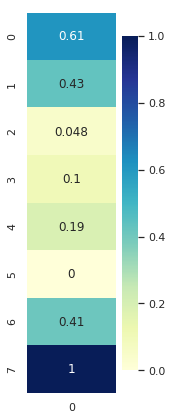

In [33]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [ ]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

In [ ]:
_, sb1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2 = model_s2.predict(x)
_, sb3 = model_s3.predict(x)
_, sb4 = model_s4.predict(x)

In [ ]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

In [ ]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

In [ ]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [ ]:
pd.DataFrame(x['sentences'][test_idx])